### Play around 

In [1]:
import caption

MLB loaded from file
Tokenizer loaded from file.


Using gpu device 0: GeForce GTX 980


In [34]:
import numpy as np
from dataset import npy2jpg

In [2]:
trX, teX, trY, teY = caption.coco(mode='dev', n_captions=5)

loading annotations into memory...
0:00:01.203773
creating index...
index created!
loading annotations into memory...
0:00:00.519408
creating index...
index created!


In [3]:
stream = caption.DataETL.getMLBStream(trX, trY, sources=('X', 'Y'))

In [4]:
x, y = stream.get_epoch_iterator().next()

In [5]:
print x.shape, y.shape

(128, 4096) (128, 14134)


In [3]:
# if i looked up dog, does the image-with-matching-multilabel vector
# contain dogs too?



In [24]:
dogindex = caption.vect.transform(['dog'])[0][0]

In [25]:
dogindex

46

In [7]:
caption.vect.transform(['on'])

[[5]]

In [8]:
import numpy as np

In [26]:
# examples which contain the word dog (token 63)
examples, = np.where(y[:, dogindex] == True)
print examples

[ 28 123]


In [27]:
# are their images close in cosine similarity?
ims = [x[idx] for idx in examples]

def mynorm(im):
    return im / np.sqrt(np.square(im).sum())

imsnormed = [mynorm(im) for im in ims]

In [28]:
from itertools import combinations
combos = combinations(imsnormed, 2)

for combo in combos:
    print np.dot(*combo)

0.405776


### Preliminary validation

In [156]:
sources = ("X", "Y")
sources_k = ("X_k", "Y_k")
predict_dir = '/home/luke/datasets/coco/predict/'
encoder_name = 'fullencoder_maxfeatures.50000_epochsampler'
# encoder_name = 'fullencoder_maxfeatures.50000'
f_emb = caption.ModelIO.load(predict_dir + encoder_name)

In [4]:
X, Y, filenames = caption.cocoXYFilenames(dataType='val2014')

loading annotations into memory...
0:00:00.634208
creating index...
index created!


In [5]:
stream = caption.DataETL.getFinalStream(X, Y, sources=sources,
            sources_k=sources_k, batch_size=10000)
mlb_stream = caption.DataETL.getMLBStream(X, Y, sources=sources,
                                        batch_size=10000)

images, captions, _0, _1 = stream.get_epoch_iterator().next()
_2, multi = mlb_stream.get_epoch_iterator().next()


In [10]:
glove_version = "glove.6B.%sd.txt.gz" % 300
gloveglove = caption.GloveTransformer(glove_version, None, caption.vect)

In [142]:
cat = "flying in the"

In [143]:
words = cat.split(' ')
print words
category_vect = []
for word in words:
    category_vect.append(
        gloveglove.vectors[gloveglove.lookup[word]]
        )
category_vect = np.vstack(category_vect)
print category_vect.shape

['flying', 'in', 'the']
(3, 300)


In [157]:
image_embs, caption_embs = f_emb(images, category_vect[None])

In [158]:
image_embs.shape, multi.shape, caption_embs.shape

((10000, 300), (10000, 14134), (1, 300))

In [159]:
vect = caption.vect

In [160]:
cat_idx = vect.transform([cat])[0][0]

In [161]:
found = caption.ModelEval.ImageSearchSingleCategory(
    image_embs, multi, caption_embs, cat_idx, .20)

n_found:  417
n_matches:  11


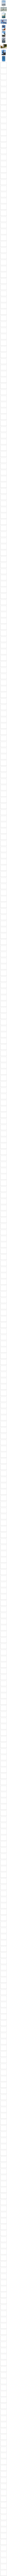

In [162]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread

img_path = "/home/luke/datasets/coco/images/val2014/"

n_found = len(found)

fig, axes = plt.subplots(n_found, 1, figsize=(5, 5*n_found))

found = sorted(found, key=lambda x: x[1], reverse=True)

# limit to 10
found = found[:10]

for i, (idx, cos_sim) in enumerate(found):
    img_file = npy2jpg(filenames[idx])
    img = imread(img_path + img_file)
    axes[i].imshow(img)
    axes[i].set_title(cat)
    axes[i].set_xlabel(cos_sim)

plt.show()

In [140]:
from scipy.spatial.distance import euclidean

def ImageSearchSingleCategory(ims, mlb_matrix, captions, category_key, thresh):
    """do a single category, like dog"""
    
    # euclidean
    distances = [euclidean(captions, im) for im in ims]
#     sims = np.dot(captions, ims.T).flatten()

    found = []
    n_found = 0
    n_matches = 0
    for i in range(len(distances)):
        if distances[i] < thresh:
            n_found += 1
            found.append((i, distances[i]))
            # depends on category_key being a single integer
            if mlb_matrix[i][category_key]:
                n_matches += 1

    print "n_found: ", n_found
    print "n_matches: ", n_matches
    return found

# found = ImageSearchSingleCategory(
#             image_embs, multi, caption_embs, cat_idx, 1.25)